# **Univariate Nonlinear Regression**
### Gauss Newton Algorithm and Levenberg-Marquardt (LM) Algorithm
For systems whose forward models are non-linearizable, we resort to iterative methods to find best estimates for parameters. The objective during iteration is to reduce the error between the predicted and measured values of the dependent variable. In this notebook, we will use temperature data obtained during the transient phase of constant-flux heating over a period of time. We have two parameters to estimate (called $a$ and $b$, which will be defined later), one of which quantifies steady state condition of the system while the other dictates the rate at which steady state will be achieved.  

In [1]:
# Dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### **Generating data from forward model**
Consider a body of mass $m$ and specific heat capacity $C_{p}$ (assuming the body is not gaseous, which keeps $C_{p}$ roughly constant over temperature) being heated starting from ambient temperature by a heat flux $Q$. The body loses heat to the ambient (which remains at a constant temperature $T_{\infty}$) by natural convection. The thermal coefficient of convection is $h$. In the heating phase, $Q$ heats the body faster than convection can cool it, and its temperature rises. This can be modeled as follows.

$$
mC_{p}\frac{dT}{dt}=Q-hA(T-T_{\infty})\quad\Rightarrow\quad T-T_{\infty}=\frac{Q}{hA}\left(1-e^{-\frac{hA}{mC_{p}}t}\right)
$$

This expression has the form $\boxed{\theta = a(1-e^{-bt})}$ where $\theta = T - T_{\infty}$ and $a$ and $b$ remain constant throughout the experiment. It soon becomes evident that this expression cannot be linearized exactly, and thus our standard Linear Least Squares optimization will not work well for us. Also notice that the derivatives of $\theta$ with $a$ and $b$ are functions of each other. This makes our optimization task much more difficult. So, we turn to a new way of estimating these parameters.

We start with a guess for $(a, b)$ and calculate the error of our predicted values of $\theta$ from the actual values. Based on how high this error is and the gradient of the function generating $\theta$ with these parameters (which tells us what direction we should move in to optimize $a$ and $b$), we update $a$ and $b$ until they reach sufficiently close to the actual values.

Below, we generate 100 data points for time between 0 and 500 seconds. For this experiment, assume $\boxed{a=40.0\;K}$ and $\boxed{b=0.005\;s^{-1}}$. Feeding these values to the function above, we get 100 points for $\theta$ varying with time. To emulate real life measurements, we add Gaussian noise with mean 0.0 and variance 1.0 to the data. This data (we'll call it $\theta_{noisy}$ this point forward) is what we want our model to be able to predict. 

In [2]:
# Function is T = a(1 - exp(-bt))
# Create data for 100 time steps, 500 sec with interval of 5 sec

a = 40.0
b = 0.005
n_samples = 100

t = np.linspace(0, 500, n_samples + 1)
T_real = a*(1.0 - np.exp(-b*t)).reshape((-1, 1))

noise = np.random.normal(loc=0, scale=1.0, size=(T_real.shape[0])).reshape((-1, 1))
T_noisy = (T_real + noise).reshape((-1, 1))

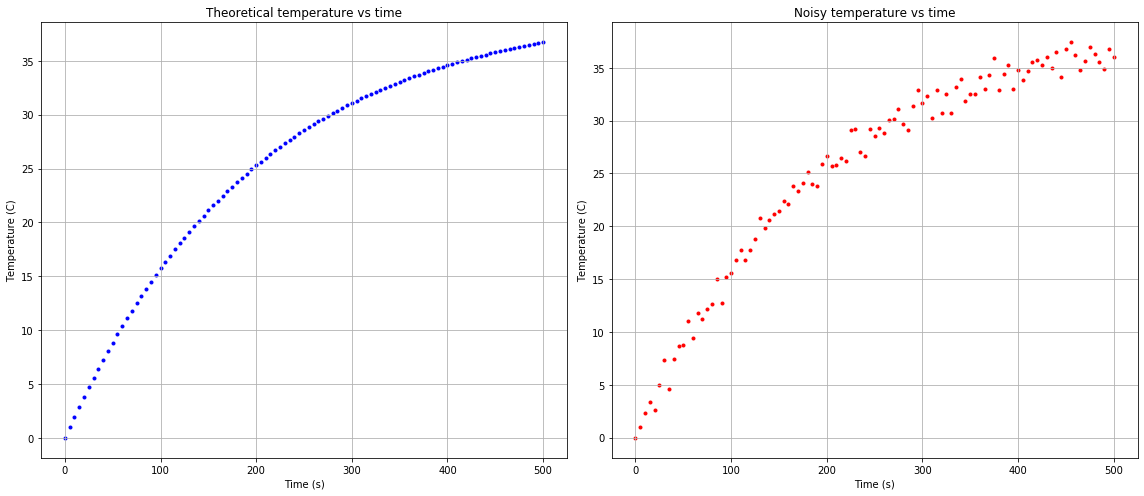

In [3]:
# Plot real and noisy temperatures
fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(121)
ax1.scatter(t, T_real, color='blue', marker='.')
ax1.grid()
ax1.set_title("Theoretical temperature vs time")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Temperature (C)")

ax2 = fig.add_subplot(122)
ax2.scatter(t, T_noisy, color='red', marker='.')
ax2.grid()
ax2.set_title('Noisy temperature vs time')
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Temperature (C)")

plt.tight_layout()
plt.show()

### **Gauss Newton Algorithm**
The equation which provides updates to $a$ and $b$ is motivated by the multivariate version of Taylor Series approximation of a function at a point $t$ at iteration $i$, given as...

$$
y^{(i+1)}=f^{(i)}(t)+\frac{\partial f^{(i)}(t)}{\partial a^{(i)}}\cdot\Delta a^{(i)}+\frac{\partial f^{(i)}(t)}{\partial b^{(i)}}\cdot\Delta b^{(i)}+e^{(i)}
$$

$e^{(i)}$ consists of higher order terms whose values we have neglected (strong assumption, but okay). This can be converted to a matrix equation as follows...

$$
D=Z\cdot dA+E
$$

... where each of the matrices stand for these terms.

$$
Z=\left[\begin{array}{cc}
\nabla_{a}f & \nabla_{b}f\end{array}\right]=\left[\begin{array}{cc}
\frac{\partial f(t_{1})}{\partial a} & \frac{\partial f(t_{1})}{\partial b}\\
\vdots & \vdots\\
\frac{\partial f(t_{n})}{\partial a} & \frac{\partial f(t_{n})}{\partial b}
\end{array}\right]\quad;\quad D=\eta\cdot\left[\begin{array}{c}
y_{1}-f(t_{1})\\
\vdots\\
y_{n}-f(t_{n})
\end{array}\right]\quad;\quad dA=\left[\begin{array}{c}
\Delta a\\
\Delta b
\end{array}\right]
$$

1. The matrix {$Z$} is called the **Jacobian Matrix**, which lists the gradients of the approximated function $f$ w.r.t $a$ and $b$ at every data point $(t, \theta)$. 
2. {$D$} is called the **Forcing Vector**, which tells how bad our predictions are compared to the true values. Here, we would like to treat positive and negative errors differently, as correcting them will need different types of changes to $a$ and $b$. The parameter $\eta$ is a scaling parameter, which helps suppress the magnitudes of error (when they are high, which could result in divergence). 
3. Finally, {$dA$} is the **Update Vector** which gives the amount of changes each parameter should get to move towards convergence.

To solve this equation, we assume $E$ to be negligible compared to the other terms. Now {$J$} cannot be inverted directly as it might not be a square matrix. We therefore manipulate the equation as follows; we have used this form for performing the iterations.

$$
Z^{T}Z\cdot dA=Z^{T}D\quad\Rightarrow\quad \boxed{dA=\left(Z^{T}Z\right)^{-1}\left(Z^{T}D\right)}
$$

However, this algorithm comes with a caveat. **GNA will converge well only if the initial guess is close to the actual values of the parameters ("close" is subjective)**. As to what happens when it's not close, and what we can do to fix that problem, we shall see subsequently.

In [4]:
# Value and Jacobian functions
def F(t, a, b):
    """The function governing temperature of the body"""
    return (a*(1-np.exp(-b*t))).reshape((-1, 1))

def J_a(t, a, b):
    """Gradient of the function w.r.t. parameter a"""
    return (1 - np.exp(-b*t)).reshape((-1, 1))

def J_b(t, a, b):
    """Gradient of the function w.r.t. parameter b"""
    return (a*t*np.exp(-b*t)).reshape((-1, 1))

In [5]:
# Initialize matrices

# Matrix to store current values of parameters
# We have initialized it close to the actual values
A = np.array([[50.0],      # <-- a
              [0.001]])    # <-- b

# Forcing vector
D = np.zeros((T_noisy.shape[0], 1))

# Jacobian matrix
z = np.zeros((T_noisy.shape[0], A.shape[0]))

# Update vector
dA = np.zeros((A.shape[0], 1))

In [6]:
# Perform iterations
a_estimates = []
b_estimates = []
eta = 0.1              # Learning rate parameter to suppress large error magnitudes

for _ in range(100):
    D = (T_noisy - F(t, A[0], A[1])) * eta
    z = np.hstack((J_a(t, A[0], A[1]), J_b(t, A[0], A[1])))
    dA = np.dot(np.linalg.pinv(np.dot(z.T, z)), np.dot(z.T, D)) 
    A += dA
    a_estimates.append(A[0][0])
    b_estimates.append(A[1][0])

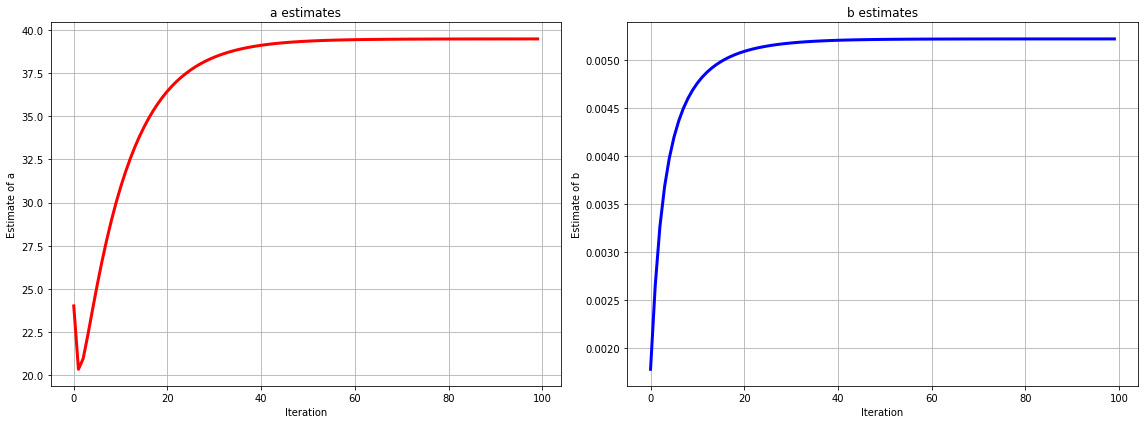

In [7]:
# Plot estimated quantities
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(a_estimates, color='red', linewidth=3)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Estimate of a')
ax1.set_title('a estimates')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(b_estimates, color='blue', linewidth=3)
ax2.set_title('b estimates')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Estimate of b')
ax2.grid()

plt.tight_layout()
plt.show()

In [8]:
# Last values attained by parameters
print("Estimated value of a \t : \t {:.6f}".format(a_estimates[-1]))
print("Estimated value of b \t : \t {:.6f}".format(b_estimates[-1]))

Estimated value of a 	 : 	 39.487694
Estimated value of b 	 : 	 0.005222


As we can see, the algorithm has successfully estimated the parameters with good accuracy. Let's go over the residuals and goodness of fit calculations quickly.

In [24]:
def get_residuals(t, T_noisy, a, b):
    """
    Returns a pandas DataFrame with residuals information
    """
    predicted_T = a*(1 - np.exp(-b*t))
    data = np.vstack((t.reshape((1, -1)), T_noisy.reshape((1, -1)), predicted_T.reshape((1, -1)))).T
    df = pd.DataFrame(data, columns=['x', 'T_measured', 'T_fit'])

    df['Mean_deviation'] = (df['T_measured'] - df['T_measured'].mean())**2
    df['Fit_deviation'] = (df['T_measured'] - df['T_fit'])**2
    return df
    
def goodness_of_fit(t, resid_df):
    """
    Prints out values of some goodness of fit parameters
    """
    S_t, S_r = resid_df['Mean_deviation'].sum(), resid_df['Fit_deviation'].sum()
    R_2 = (S_t - S_r)/S_t
    SE = np.sqrt(S_r/(len(t) - 2))

    print('Total fit deviation (squared) \t : \t {:.6f}'.format(resid_df['Fit_deviation'].sum()))
    print("Coefficient of determination \t : \t {}".format(R_2))
    print("Correlation coefficient \t : \t {}".format(R_2**0.5))
    print("Standard error for fit \t\t : \t {}\n".format(SE))

In [26]:
# Print residuals
resid_df = get_residuals(t, T_noisy, A[0], A[1])
print('-------------------------------------------------------------------')
print("Residuals")
print('-------------------------------------------------------------------')
print(resid_df)
print('\n')
print('-------------------------------------------------------------------')
print('Goodness of fit metrics')
print('-------------------------------------------------------------------')

# Print goodness of fit metrics
goodness_of_fit(t, resid_df)

-------------------------------------------------------------------
Residuals
-------------------------------------------------------------------
         x  T_measured      T_fit  Mean_deviation  Fit_deviation
0      0.0   -0.028657   0.000000      645.981688       0.000821
1      5.0    0.968918   1.017713      596.267769       0.002381
2     10.0    2.312450   2.009196      532.458518       0.091963
3     15.0    3.420996   2.975126      482.527871       0.198800
4     20.0    2.623591   3.916161      518.196146       1.670737
..     ...         ...        ...             ...            ...
96   480.0   36.295832  36.267802      118.991422       0.000786
97   485.0   35.528754  36.350788      102.844768       0.675740
98   490.0   34.873643  36.431635       89.986656       2.427341
99   495.0   36.795913  36.510399      130.151593       0.081518
100  500.0   36.043103  36.587132      113.541591       0.295968

[101 rows x 5 columns]


------------------------------------------------

**Some remarks**

One thing to observe is that the algorithm does not converge to the same pair of estimates over runs. This is happening only because of the variable noise we add in every run. Otherwise, the process as such is deterministic and should give the same estimates if the system parameters (initializations, etc.) are undisturbed.

### **Gauss Newton Algorithm with bad initialization**
What happens if our initial guess is far away from the actual values? Below, we start with $a=80.0$ and $b=0.0005$, which is sufficiently bad (in my opinion, at least).

In [27]:
# Initialize matrices

# Matrix to store current values of parameters
# We have initialized it close to the actual values
A = np.array([[80.0],       # <-- a
              [0.0005]])    # <-- b

# Forcing vector
D = np.zeros((T_noisy.shape[0], 1))

# Jacobian matrix
z = np.zeros((T_noisy.shape[0], A.shape[0]))

# Update vector
dA = np.zeros((A.shape[0], 1))

In [28]:
# Perform iterations
a_estimates = []
b_estimates = []
eta = 0.1              # Learning rate parameter to suppress large error magnitudes

for _ in range(100):
    D = (T_noisy - F(t, A[0], A[1])) * eta
    z = np.hstack((J_a(t, A[0], A[1]), J_b(t, A[0], A[1])))
    dA = np.dot(np.linalg.pinv(np.dot(z.T, z)), np.dot(z.T, D)) 
    A += dA
    a_estimates.append(A[0][0])
    b_estimates.append(A[1][0])

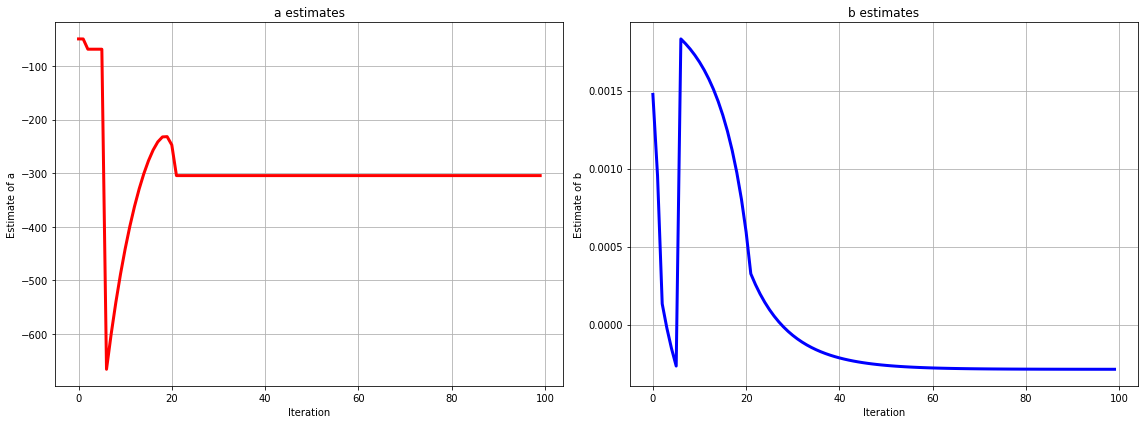

In [29]:
# Plot estimated quantities
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(a_estimates, color='red', linewidth=3)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Estimate of a')
ax1.set_title('a estimates')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(b_estimates, color='blue', linewidth=3)
ax2.set_title('b estimates')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Estimate of b')
ax2.grid()

plt.tight_layout()
plt.show()

In [30]:
# Print residuals
resid_df = get_residuals(t, T_noisy, A[0], A[1])
print('-------------------------------------------------------------------')
print("Residuals")
print('-------------------------------------------------------------------')
print(resid_df)
print('\n')
print('-------------------------------------------------------------------')
print('Goodness of fit metrics')
print('-------------------------------------------------------------------')

# Print goodness of fit metrics
goodness_of_fit(t, resid_df)

-------------------------------------------------------------------
Residuals
-------------------------------------------------------------------
         x  T_measured      T_fit  Mean_deviation  Fit_deviation
0      0.0   -0.028657  -0.000000      645.981688       0.000821
1      5.0    0.968918   0.436004      596.267769       0.283997
2     10.0    2.312450   0.872633      532.458518       2.073073
3     15.0    3.420996   1.309887      482.527871       4.456779
4     20.0    2.623591   1.747768      518.196146       0.767066
..     ...         ...        ...             ...            ...
96   480.0   36.295832  44.835972      118.991422      72.933995
97   485.0   35.528754  45.336189      102.844768      96.185784
98   490.0   34.873643  45.837122       89.986656     120.197889
99   495.0   36.795913  46.338773      130.151593      91.066179
100  500.0   36.043103  46.841142      113.541591     116.597663

[101 rows x 5 columns]


------------------------------------------------

You can see from the analysis above that the algorithm has absolutely no idea where to go, and settles at horribly wrong estimates. Why could this happen? Perhaps because of the awkwardly large values attained by gradients in the Jacobian matrix. It is seen that GNA misbehaves when the condition given below is (sufficiently) true.

$$
\boxed{\det\left(Z^{T}Z\right)\approx0}
$$

This condition is often used to check **ill-posedness of the inverse problem**. Intuitively, you may realize that the extreme case of $\det\left(Z^{T}Z\right)=0$ prevents us from inverting the matrix (singular matrices cannot be inverted) and thus prevents us from calculating $dA$. In general, smaller the value of $\det\left(Z^{T}Z\right)$ is, higher (and more unstable) will the values of $dA$ be. What can we do to prevent this from happening? Our next algorithm comes to the rescue!

### **Improving GNA: Levenberg Algorithm**
Essentially, if we take the $\det \left(Z^{T}Z\right)$ away from zero (as much as possible), we should do fine. A simple idea, as suggested by Kenneth Levenberg, was to do this:

$$
dA=\left(Z^{T}Z + \lambda I \right)^{-1}\left(Z^{T}D\right)
$$

where $I$ is the identity matrix of appropriate dimensions and $\lambda$ is a regularization parameter (more on that in a different notebook). This ensures that the diagonal of $Z^{T}Z$ always has non-zero numbers, so the matrix will never be singular (note that $Z^{T}Z$ is a symmetric matrix). Starting with the bad guess, let's see how this fares for us.

In [31]:
# Initialize matrices

# Matrix to store current values of parameters
# We have initialized it close to the actual values
A = np.array([[80.0],       # <-- a
              [0.0005]])    # <-- b

# Forcing vector
D = np.zeros((T_noisy.shape[0], 1))

# Jacobian matrix
z = np.zeros((T_noisy.shape[0], A.shape[0]))

# Update vector
dA = np.zeros((A.shape[0], 1))

In [32]:
# Perform iterations for Levenberg Algorithm
a_estimates = []
b_estimates = []
eta = 0.1              # Learning rate parameter to suppress large error magnitudes
lbd = 0.01             # Regularization parameter for Levenberg Algorithm

for _ in range(100):
    D = (T_noisy - F(t, A[0], A[1])) * eta
    z = np.hstack((J_a(t, A[0], A[1]), J_b(t, A[0], A[1])))
    zt_z = np.dot(z.T, z)
    dA = np.dot(np.linalg.pinv(zt_z + lbd * np.identity(zt_z.shape[0])), np.dot(z.T, D)) 
    A += dA
    a_estimates.append(A[0][0])
    b_estimates.append(A[1][0])

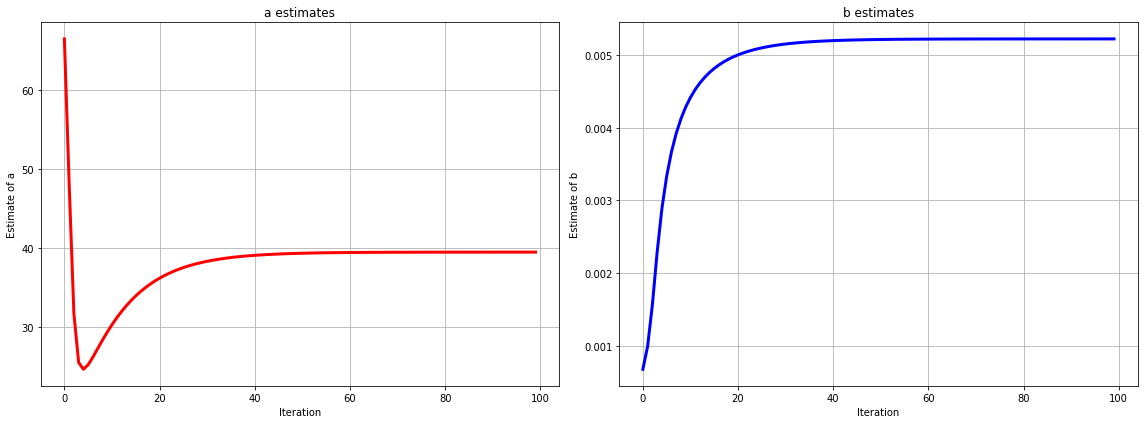

In [33]:
# Plot estimated quantities
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(a_estimates, color='red', linewidth=3)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Estimate of a')
ax1.set_title('a estimates')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(b_estimates, color='blue', linewidth=3)
ax2.set_title('b estimates')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Estimate of b')
ax2.grid()

plt.tight_layout()
plt.show()

In [35]:
# Last values attained by parameters
print("Estimated value of a \t : \t {:.6f}".format(a_estimates[-1]))
print("Estimated value of b \t : \t {:.6f}".format(b_estimates[-1]))

Estimated value of a 	 : 	 39.487608
Estimated value of b 	 : 	 0.005222


In [34]:
# Print residuals
resid_df = get_residuals(t, T_noisy, A[0], A[1])
print('-------------------------------------------------------------------')
print("Residuals")
print('-------------------------------------------------------------------')
print(resid_df)
print('\n')
print('-------------------------------------------------------------------')
print('Goodness of fit metrics')
print('-------------------------------------------------------------------')

# Print goodness of fit metrics
goodness_of_fit(t, resid_df)

-------------------------------------------------------------------
Residuals
-------------------------------------------------------------------
         x  T_measured      T_fit  Mean_deviation  Fit_deviation
0      0.0   -0.028657   0.000000      645.981688       0.000821
1      5.0    0.968918   1.017708      596.267769       0.002380
2     10.0    2.312450   2.009186      532.458518       0.091969
3     15.0    3.420996   2.975111      482.527871       0.198813
4     20.0    2.623591   3.916142      518.196146       1.670688
..     ...         ...        ...             ...            ...
96   480.0   36.295832  36.267701      118.991422       0.000791
97   485.0   35.528754  36.350687      102.844768       0.675574
98   490.0   34.873643  36.431534       89.986656       2.427026
99   495.0   36.795913  36.510298      130.151593       0.081576
100  500.0   36.043103  36.587032      113.541591       0.295859

[101 rows x 5 columns]


------------------------------------------------

**Much better!** Even with the bad guess, our new algorithm helps us get to the right values soon enough. What happens at other values of $\lambda$? Let's find out!

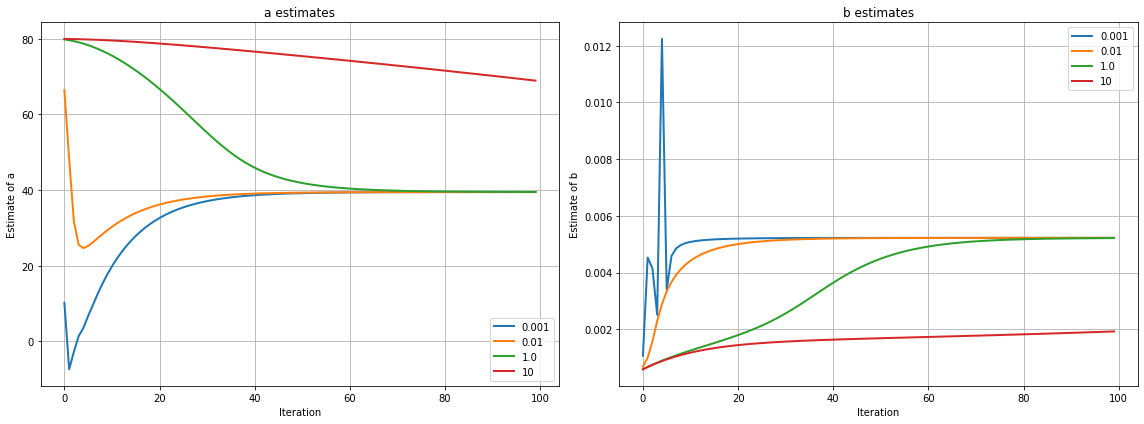

In [45]:
# Perform iterations for Levenberg Algorithm

eta = 0.1                           # Learning rate parameter to suppress large error magnitudes
lbd_vals = [0.001, 0.01, 1.0, 10]   # Regularization parameter for Levenberg Algorithm

# Generate plotting planes
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Estimate of a')
ax1.set_title('a estimates')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.set_title('b estimates')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Estimate of b')
ax2.grid()

# Loop over each value of lambda
for lbd in lbd_vals:
    
    # Reinitialize all matrices and lists
    A = np.array([[80.0],       # <-- a
                  [0.0005]])    # <-- b
    D = np.zeros((T_noisy.shape[0], 1))
    z = np.zeros((T_noisy.shape[0], A.shape[0]))
    dA = np.zeros((A.shape[0], 1))
    
    a_estimates = []
    b_estimates = []
    
    for _ in range(100):
        D = (T_noisy - F(t, A[0], A[1])) * eta
        z = np.hstack((J_a(t, A[0], A[1]), J_b(t, A[0], A[1])))
        zt_z = np.dot(z.T, z)
        dA = np.dot(np.linalg.pinv(zt_z + lbd * np.identity(zt_z.shape[0])), np.dot(z.T, D)) 
        A += dA
        a_estimates.append(A[0][0])
        b_estimates.append(A[1][0])
        
    # Plot the results
    ax1.plot(a_estimates, linewidth=2, label=str(lbd))
    ax2.plot(b_estimates, linewidth=2, label=str(lbd))

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

It seems $\lambda$ could really be anything, but it takes longer to converge if its value is large. Also note that very small values of $\lambda$ have a disturbed transient state before they stabilize. This isn't visible in moderately large $\lambda$ values.

### **Improving GNA: Levenberg-Marquardt Algorithm**
Why stop with $\lambda I$? Donald Marquardt suggests that we use the diagonal of $\left(Z^{T}Z\right)$ instead. Our equation now looks this:

$$
dA=\left(Z^{T}Z + \lambda \cdot diag\left(Z^{T}Z \right) \right)^{-1}\left(Z^{T}D\right)
$$

It serves the same purpose; let's see if performs any better.

In [46]:
# Initialize matrices

# Matrix to store current values of parameters
# We have initialized it close to the actual values
A = np.array([[80.0],       # <-- a
              [0.0005]])    # <-- b

# Forcing vector
D = np.zeros((T_noisy.shape[0], 1))

# Jacobian matrix
z = np.zeros((T_noisy.shape[0], A.shape[0]))

# Update vector
dA = np.zeros((A.shape[0], 1))

In [50]:
# Perform iterations for Levenberg Algorithm
a_estimates = []
b_estimates = []
eta = 0.1              # Learning rate parameter to suppress large error magnitudes
lbd = 0.01             # Regularization parameter for Levenberg Algorithm

for _ in range(100):
    D = (T_noisy - F(t, A[0], A[1])) * eta
    z = np.hstack((J_a(t, A[0], A[1]), J_b(t, A[0], A[1])))
    zt_z = np.dot(z.T, z)
    dA = np.dot(np.linalg.pinv(zt_z + lbd * np.identity(zt_z.shape[0]) * zt_z), np.dot(z.T, D)) 
    A += dA
    a_estimates.append(A[0][0])
    b_estimates.append(A[1][0])

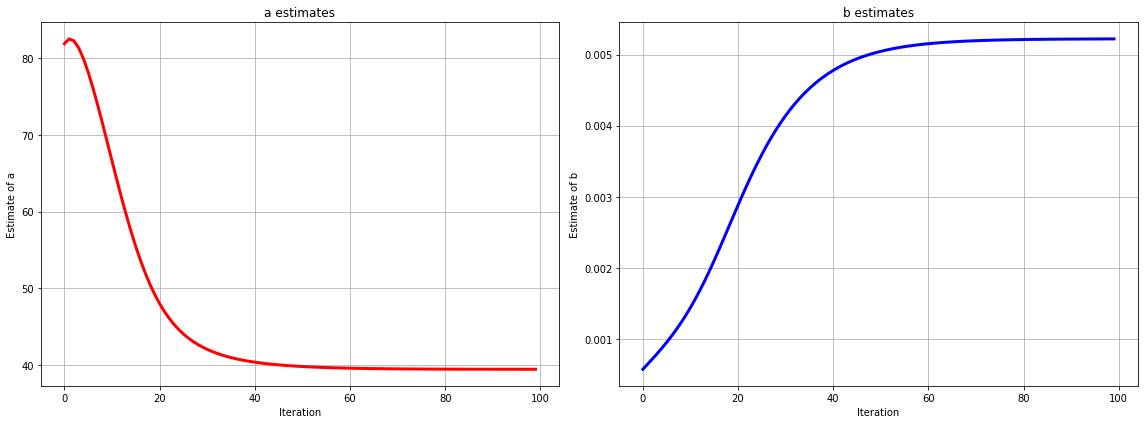

In [51]:
# Plot estimated quantities
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(a_estimates, color='red', linewidth=3)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Estimate of a')
ax1.set_title('a estimates')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(b_estimates, color='blue', linewidth=3)
ax2.set_title('b estimates')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Estimate of b')
ax2.grid()

plt.tight_layout()
plt.show()

In [52]:
# Last values attained by parameters
print("Estimated value of a \t : \t {:.6f}".format(a_estimates[-1]))
print("Estimated value of b \t : \t {:.6f}".format(b_estimates[-1]))

Estimated value of a 	 : 	 39.492775
Estimated value of b 	 : 	 0.005220


In [53]:
# Print residuals
resid_df = get_residuals(t, T_noisy, A[0], A[1])
print('-------------------------------------------------------------------')
print("Residuals")
print('-------------------------------------------------------------------')
print(resid_df)
print('\n')
print('-------------------------------------------------------------------')
print('Goodness of fit metrics')
print('-------------------------------------------------------------------')

# Print goodness of fit metrics
goodness_of_fit(t, resid_df)

-------------------------------------------------------------------
Residuals
-------------------------------------------------------------------
         x  T_measured      T_fit  Mean_deviation  Fit_deviation
0      0.0   -0.028657   0.000000      645.981688       0.000821
1      5.0    0.968918   1.017509      596.267769       0.002361
2     10.0    2.312450   2.008803      532.458518       0.092201
3     15.0    3.420996   2.974557      482.527871       0.199308
4     20.0    2.623591   3.915429      518.196146       1.668845
..     ...         ...        ...             ...            ...
96   480.0   36.295832  36.269783      118.991422       0.000679
97   485.0   35.528754  36.352821      102.844768       0.679087
98   490.0   34.873643  36.433720       89.986656       2.433843
99   495.0   36.795913  36.512535      130.151593       0.080303
100  500.0   36.043103  36.589319      113.541591       0.298353

[101 rows x 5 columns]


------------------------------------------------

Compared to the case when only Levenberg algorithm was used, we have much smoother and jerk-less convergence with the Levenberg-Marquardt algorithm. So in a way, this algorithm is slight improvement of the Levenberg algorithm. Again, let's see how it performs for different values of $\lambda$.

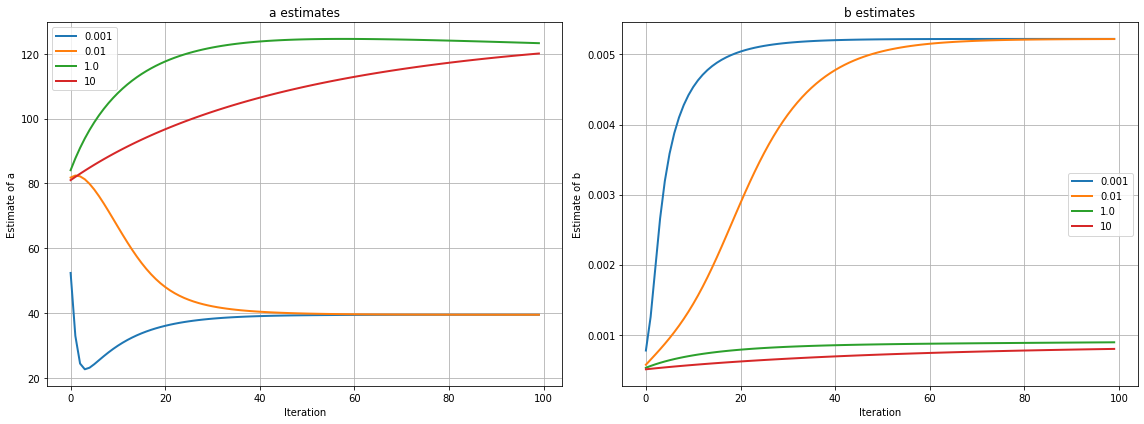

In [54]:
# Perform iterations for Levenberg Algorithm

eta = 0.1                           # Learning rate parameter to suppress large error magnitudes
lbd_vals = [0.001, 0.01, 1.0, 10]   # Regularization parameter for Levenberg Algorithm

# Generate plotting planes
fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Estimate of a')
ax1.set_title('a estimates')
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.set_title('b estimates')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Estimate of b')
ax2.grid()

# Loop over each value of lambda
for lbd in lbd_vals:
    
    # Reinitialize all matrices and lists
    A = np.array([[80.0],       # <-- a
                  [0.0005]])    # <-- b
    D = np.zeros((T_noisy.shape[0], 1))
    z = np.zeros((T_noisy.shape[0], A.shape[0]))
    dA = np.zeros((A.shape[0], 1))
    
    a_estimates = []
    b_estimates = []
    
    for _ in range(100):
        D = (T_noisy - F(t, A[0], A[1])) * eta
        z = np.hstack((J_a(t, A[0], A[1]), J_b(t, A[0], A[1])))
        zt_z = np.dot(z.T, z)
        dA = np.dot(np.linalg.pinv(zt_z + lbd * np.identity(zt_z.shape[0]) * zt_z), np.dot(z.T, D)) 
        A += dA
        a_estimates.append(A[0][0])
        b_estimates.append(A[1][0])
        
    # Plot the results
    ax1.plot(a_estimates, linewidth=2, label=str(lbd))
    ax2.plot(b_estimates, linewidth=2, label=str(lbd))

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

Here's an interesting observation. If $\lambda$ is too high, our algorithm seems to diverge. It may converge in the long run, but it seems to perform poorly for less number of iterations.

### **Robustness Check**
Let's try some really bad guesses and see which algorithm converges reasonably. We'll check only among the latter two, since we know that GNA will collapse.

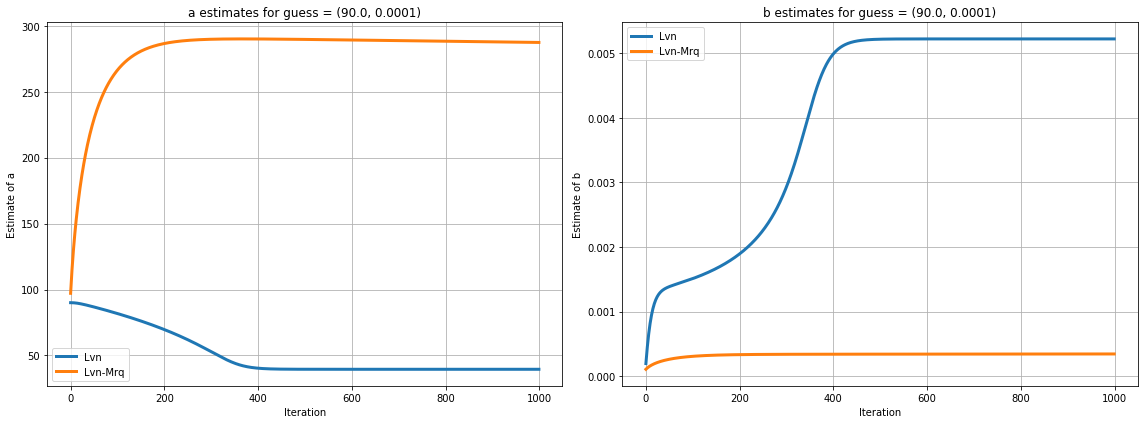

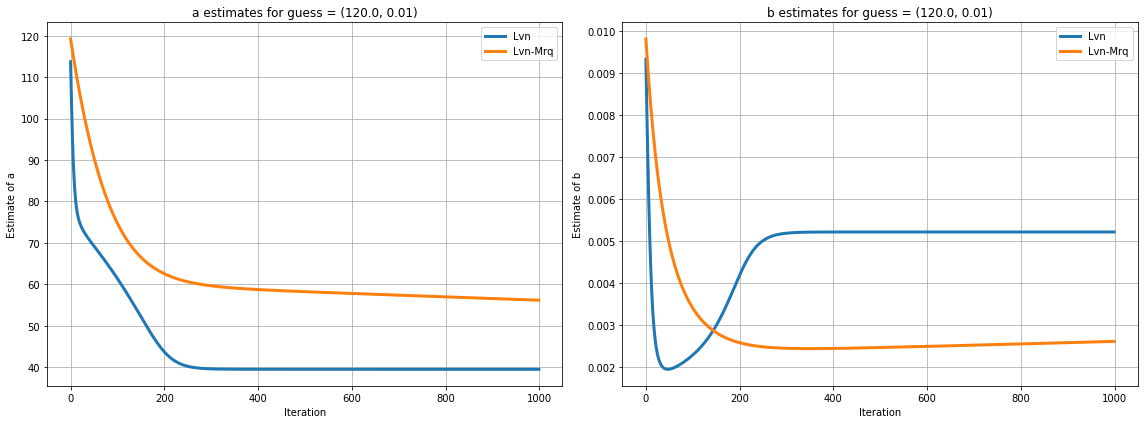

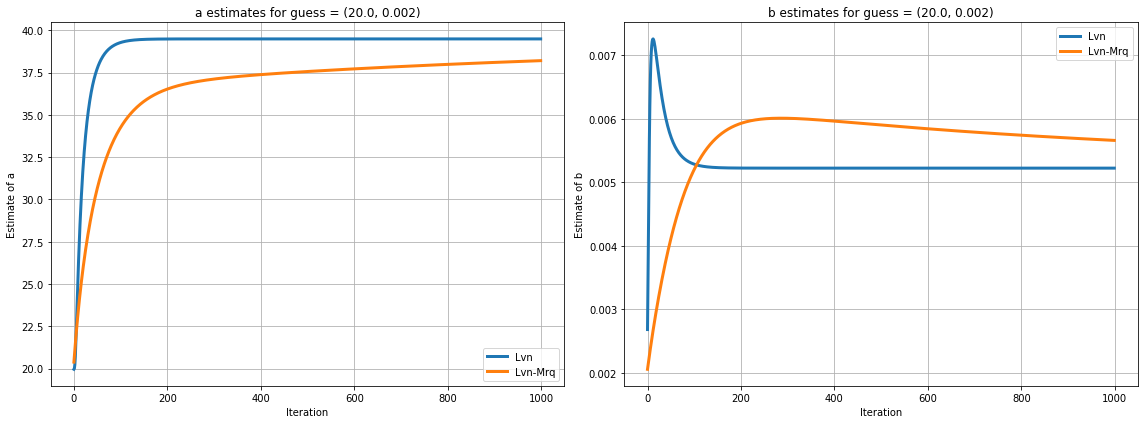

In [58]:
# Perform iterations for Levenberg Algorithm

eta = 0.1         # Learning rate parameter to suppress large error magnitudes
lbd_vals = 0.01   # Regularization parameter for Levenberg Algorithm

guesses = [(90.0, 0.0001), (120.0, 0.01), (20.0, 0.002)]  # Some bad guesses


# Loop over each guess pair and method
for guess in guesses:
    
    # Generate plotting planes
    fig = plt.figure(figsize=(16, 6))

    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Estimate of a')
    ax1.set_title('a estimates for guess = {}'.format(guess))
    ax1.grid()

    ax2 = fig.add_subplot(122)
    ax2.set_title('b estimates for guess = {}'.format(guess))
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Estimate of b')
    ax2.grid()
    
    for method in ['Lvn', 'Lvn-Mrq']:

        # Reinitialize all matrices and lists
        A = np.array([[guess[0]],     # <-- a
                      [guess[1]]])    # <-- b
        D = np.zeros((T_noisy.shape[0], 1))
        z = np.zeros((T_noisy.shape[0], A.shape[0]))
        dA = np.zeros((A.shape[0], 1))

        a_estimates = []
        b_estimates = []

        if method == 'Lvn':
            for _ in range(1000):
                D = (T_noisy - F(t, A[0], A[1])) * eta
                z = np.hstack((J_a(t, A[0], A[1]), J_b(t, A[0], A[1])))
                zt_z = np.dot(z.T, z)
                dA = np.dot(np.linalg.pinv(zt_z + lbd * np.identity(zt_z.shape[0])), np.dot(z.T, D)) 
                A += dA
                a_estimates.append(A[0][0])
                b_estimates.append(A[1][0])
        elif method == 'Lvn-Mrq':
            for _ in range(1000):
                D = (T_noisy - F(t, A[0], A[1])) * eta
                z = np.hstack((J_a(t, A[0], A[1]), J_b(t, A[0], A[1])))
                zt_z = np.dot(z.T, z)
                dA = np.dot(np.linalg.pinv(zt_z + lbd * np.identity(zt_z.shape[0]) * zt_z), np.dot(z.T, D)) 
                A += dA
                a_estimates.append(A[0][0])
                b_estimates.append(A[1][0])

        # Plot the results
        ax1.plot(a_estimates, linewidth=3, label=method)
        ax2.plot(b_estimates, linewidth=3, label=method)

    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    plt.show()

It seems for our current configuration, Levenberg algorithm performs better than Levenberg-Marquardt algorithm. Feel free to fiddle around with the parameters and see if tables turn for some other configuration!

### **Endnote**

All this is fine, but we have a fundamental problem here. For doing all of what we did above, we had to tell the algorithm `J_a` and `J_b`, or the functions to compute the derivative of the $\theta$ function with $a$ and $b$. What is they are too difficult to compute or code down? In the next notebook, we'll see a more computation-friendly way of implementing these algorithms, through the **Finite-Difference Method**.